# Import lib


In [1]:
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,BatchNormalization,MaxPooling2D,Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

# useful for getting number of output classes
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

# Dataset

In [2]:
train_path = 'colored_images_mod/train'
test_path = 'colored_images_mod/test'

In [3]:
classes = glob('colored_images_mod/train/*')

In [4]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 10,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 2929 images belonging to 5 classes.


In [6]:
test_set = test_datagen.flow_from_directory(test_path,
                                           target_size = (224, 224),
                                           batch_size = 64,
                                           class_mode = 'categorical')

Found 733 images belonging to 5 classes.


# Model 

In [7]:
IMAGE_SHAPE = [224,224]

# we need to keep the weights same as the original model and just drop first and last layer
# Here we will be using imagenet weights
vggmodel = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [8]:
# summarize filters in each convolutional layer
from tensorflow.keras.applications.vgg19 import VGG19
from matplotlib import pyplot
# load the model
model = VGG19()
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5: None -- [Errno 11001] getaddrinfo failed

In [8]:
filter1 = vggmodel.get_layer('block1_conv1').output

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

# define input tensor
inputs = Input(shape=(224,224,3))

# build VGG19 model
vgg = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)

# get the block1_conv1 layer from VGG19
vgg_layer = vgg.get_layer('block1_conv1')

# get the output tensor from the VGG19 model
vgg_output = vgg_layer.output

# build your custom model
cnn = Conv2D(filters=64,kernel_size=(1,1), activation='relu')(inputs)
add = Add()([cnn,vgg_output])

cnn1 = Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu')(add)
bnor1 = BatchNormalization()(cnn1)
max1 = MaxPooling2D(pool_size=(2,2))(bnor1)

cnn2 = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(max1)

bnor2 = BatchNormalization()(cnn2)
max2 = MaxPooling2D(pool_size=(3,3))(bnor2)

cnn3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(max2)

bnor3 = BatchNormalization()(cnn3)

cnn4 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor3)
bnor4 = BatchNormalization()(cnn4)

cnn5 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor4)
bnor5 = BatchNormalization()(cnn5)

cnn6 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor5)
bnor6 = BatchNormalization()(cnn6)

cnn7 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor6)
bnor7 = BatchNormalization()(cnn7)
max3 = MaxPooling2D(pool_size=(2,2))(bnor7)

flat = Flatten()(max3)
dense1  = Dense(1024, activation = 'relu')(flat)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(1024, activation = 'relu')(drop1)
dense3 = Dense(1024, activation = 'relu')(dense2)
drop2 = Dropout(0.5)(dense3)
outputs = Dense(5, activation = 'softmax')(drop2)

# create the combined model
model = Model(inputs=inputs, outputs=outputs)

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [22]:
# model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 224, 224, 64) 256         input_12[0][0]                   
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_12[0][0]                   
__________________________________________________________________________________________________
add_5 (Add)                     (None, 224, 224, 64) 0           conv2d_39[0][0]                  
                                                                 block1_conv1[0][0]         

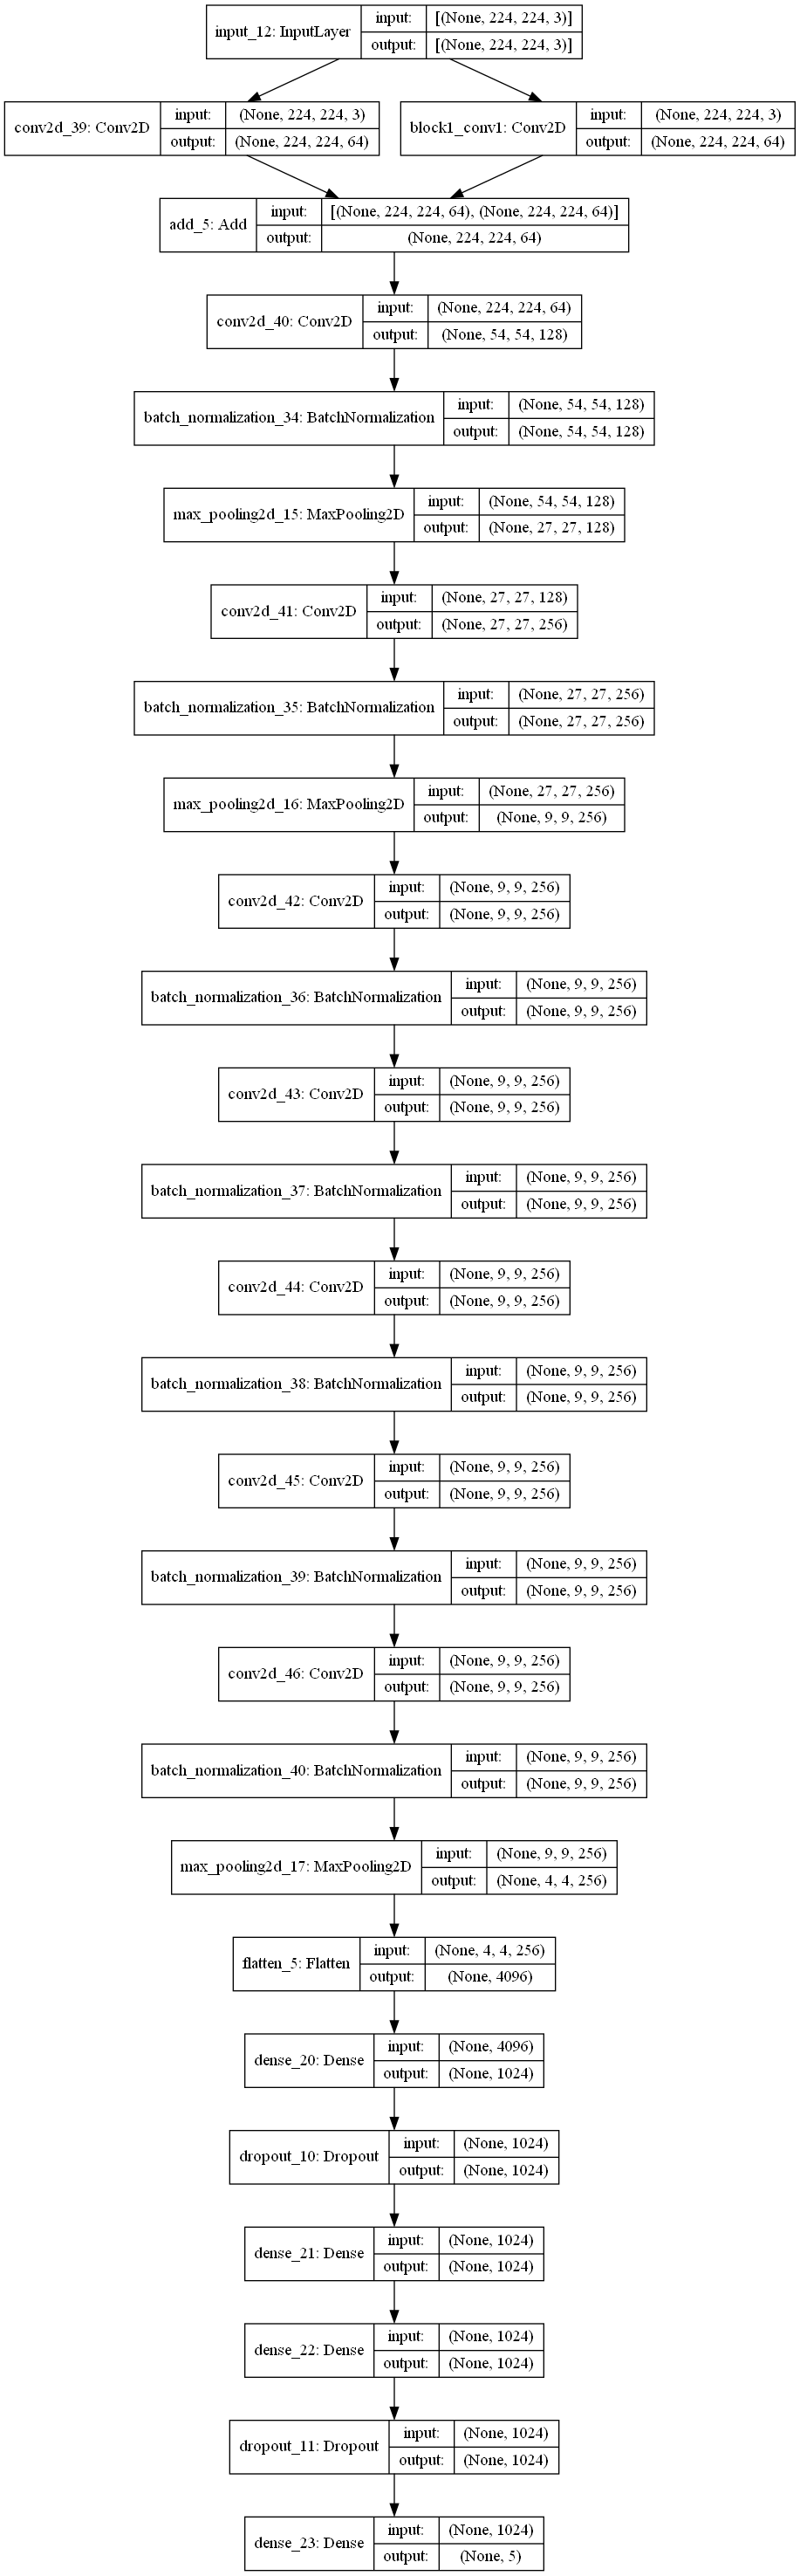

In [23]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# model = Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam()
opt = mixed_precision.LossScaleOptimizer(opt)

# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

r = model.fit(
    training_set,
    validation_data = test_set,
    epochs = 50,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    # batch_size=32  # reduce batch size
)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block1_conv1/Relu' defined at (most recent call last):
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Devansh\AppData\Local\Temp\ipykernel_20640\3842372972.py", line 11, in <module>
      r = model.fit(
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/block1_conv1/Relu'
OOM when allocating tensor with shape[64,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3628]

In [12]:
import tensorflow as tf
from keras.backend import set_session

# Set the CPU as the default device
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 0})
sess = tf.compat.v1.Session(config=config)
set_session(sess)

# Train your model on the CPU
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=50,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)


Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block1_conv1/Relu' defined at (most recent call last):
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Devansh\AppData\Local\Temp\ipykernel_20640\3842372972.py", line 11, in <module>
      r = model.fit(
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\Devansh\anaconda3\envs\env_cnn\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/block1_conv1/Relu'
OOM when allocating tensor with shape[64,224,224,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3628]

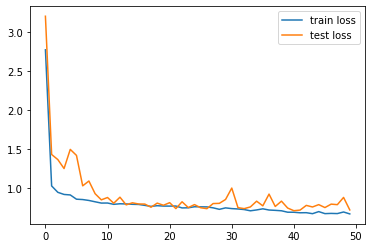

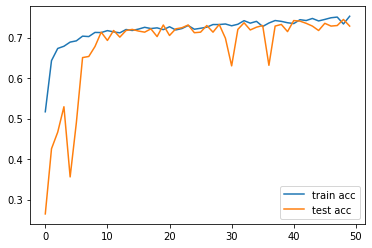

In [33]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()

# The earlier code

In [18]:
# Define the model parameters using functional api

inputs = Input(shape=(224,224,3))
cnn = Conv2D(filters=64,kernel_size=(1,1), activation='relu')(inputs)
add = Add()([cnn, filter1])

cnn1 = Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu')(add)
bnor1 = BatchNormalization()(cnn1)
max1 = MaxPooling2D(pool_size=(2,2))(bnor1)

cnn2 = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(max1)

bnor2 = BatchNormalization()(cnn2)
max2 = MaxPooling2D(pool_size=(3,3))(bnor2)


cnn3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(max2)

bnor3 = BatchNormalization()(cnn3)

cnn4 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor3)
bnor4 = BatchNormalization()(cnn4)

cnn5 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor4)
# add = Add()([cnn5,cnn3])
bnor5 = BatchNormalization()(cnn5)

cnn6 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor5)
bnor6 = BatchNormalization()(cnn6)

cnn7 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor6)
# add1 = Add()([cnn7,bnor5,cnn3])
bnor7 = BatchNormalization()(cnn7)
max3 = MaxPooling2D(pool_size=(2,2))(bnor7)

flat = Flatten()(max3)
dense1  = Dense(1024, activation = 'relu')(flat)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(1024, activation = 'relu')(drop1)
# add2 = Add()([dense2,dense1])
dense3 = Dense(1024, activation = 'relu')(dense2)
# add3 = Add()([dense3,dense1])
drop2 = Dropout(0.5)(dense3)
outputs = Dense(5, activation = 'softmax')(drop2)

model = Model(inputs=inputs, outputs=outputs, name='UGP_model') # defining the model

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'") at layer "block1_conv1". The following previous layers were accessed without issue: ['conv2d_16']

In [27]:
r = model.fit(
    training_set,
    validation_data = test_set,
    epochs = 50,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
    batch_size= 32  # reduce batch size
)

SyntaxError: invalid syntax (<ipython-input-27-3edcb0023f33>, line 7)